# Fossil Fuel Spatial Autocorrelation Notebook

### Author: Rachel Lu

### Description:


# Import Libraries

In [1]:

# the usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px


/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Import Data

Import California Power Plant dataset. 

In [2]:
cpp = gpd.read_file('California_Power_Plants_MP Cleaned 3.1.21.csv')

# Data Exploration

Let's explore our data. 

In [3]:
type(cpp)

geopandas.geodataframe.GeoDataFrame

In [4]:
cpp.shape

(871, 25)

In [5]:
cpp.head(5)

,Plant_ID,Plant_Label,MW,Gross_MWh,Net_MWh,General_Fuel,Status,Online_Year,REAT_ID,County,...,Congressional_District,CES30_PercentileRange,CES30_Percentile,Longitude,Latitude,Operation_Job,Capacity_Factor,Income_Percent,Project_Location,geometry
0,E0006,Burney Mtn. Power,11,,,Biomass,Operating,1985,C-3,Shasta,...,Congressional District 1,50-55%,51,-121.6395876,40.91000072,,,61,Neither Low Income Nor Disadvantaged Community,None
1,E0056,Mt. Lassen Power,11.4,,,Biomass,Operating,1985,C-4,Lassen,...,Congressional District 1,30-35%,30,-121.0178306,40.29741968,,,66,Neither Low Income Nor Disadvantaged Community,None
2,E0113,Commerce,11.5,,,Biomass,Operating,1986,F-11,Los Angeles,...,Congressional District 40,95-100% (highest scores),97,-118.1537915,33.99486138,,,75,Disadvantaged Community,None
3,E0026,Collins Pine,12,15398.03,8763,Biomass,Operating,1985,C-4,Plumas,...,Congressional District 1,20-25%,24,-121.2439679,40.30207759,,0.08313411,70,Neither Low Income Nor Disadvantaged Community,None
4,E0018,Chowchilla II,12.5,79062.01,67181,Biomass,Standby,2008,D-8,Madera,...,Congressional District 16,70-75%,72,-120.2488396,37.10692537,,0.61184882,48,Low Income,None


In [6]:
cpp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Plant_ID                871 non-null    object  
 1   Plant_Label             871 non-null    object  
 2   MW                      871 non-null    object  
 3   Gross_MWh               871 non-null    object  
 4   Net_MWh                 871 non-null    object  
 5   General_Fuel            871 non-null    object  
 6   Status                  871 non-null    object  
 7   Online_Year             871 non-null    object  
 8   REAT_ID                 871 non-null    object  
 9   County                  871 non-null    object  
 10  State_                  871 non-null    object  
 11  Renewable_Energy        871 non-null    object  
 12  Jobs                    871 non-null    object  
 13  Senate_District         871 non-null    object  
 14  Assembly_District 

# Clean Data

Let's rename some of our columns so they're easier to work with and more intuitive. 

In [7]:
list(cpp)

['Plant_ID',
 'Plant_Label',
 'MW',
 'Gross_MWh',
 'Net_MWh',
 'General_Fuel',
 'Status',
 'Online_Year',
 'REAT_ID',
 'County',
 'State_',
 'Renewable_Energy',
 'Jobs',
 'Senate_District',
 'Assembly_District',
 'Congressional_District',
 'CES30_PercentileRange',
 'CES30_Percentile',
 'Longitude',
 'Latitude',
 'Operation_Job',
 'Capacity_Factor',
 'Income_Percent',
 'Project_Location',
 'geometry']

In [8]:
cpp.columns = ['Plant_ID',
 'Name',
 'MW',
 'Gross_MWh',
 'Net_MWh',
 'Fuel_Type',
 'Status',
 'Online_Year',
 'REAT_ID',
 'County',
 'State',
 'Renewable_Energy',
 'Jobs',
 'Senate_District',
 'Assembly_District',
 'Congressional_District',
 'CES30_PercentileRange',
 'CES30_Percentile',
 'Lon',
 'Lat',
 'Operation_Job',
 'Capacity_Factor',
 'Income_Percent',
 'Project_Location',
 'geometry']

In [9]:
cpp.head(5)

,Plant_ID,Name,MW,Gross_MWh,Net_MWh,Fuel_Type,Status,Online_Year,REAT_ID,County,...,Congressional_District,CES30_PercentileRange,CES30_Percentile,Lon,Lat,Operation_Job,Capacity_Factor,Income_Percent,Project_Location,geometry
0,E0006,Burney Mtn. Power,11,,,Biomass,Operating,1985,C-3,Shasta,...,Congressional District 1,50-55%,51,-121.6395876,40.91000072,,,61,Neither Low Income Nor Disadvantaged Community,None
1,E0056,Mt. Lassen Power,11.4,,,Biomass,Operating,1985,C-4,Lassen,...,Congressional District 1,30-35%,30,-121.0178306,40.29741968,,,66,Neither Low Income Nor Disadvantaged Community,None
2,E0113,Commerce,11.5,,,Biomass,Operating,1986,F-11,Los Angeles,...,Congressional District 40,95-100% (highest scores),97,-118.1537915,33.99486138,,,75,Disadvantaged Community,None
3,E0026,Collins Pine,12,15398.03,8763,Biomass,Operating,1985,C-4,Plumas,...,Congressional District 1,20-25%,24,-121.2439679,40.30207759,,0.08313411,70,Neither Low Income Nor Disadvantaged Community,None
4,E0018,Chowchilla II,12.5,79062.01,67181,Biomass,Standby,2008,D-8,Madera,...,Congressional District 16,70-75%,72,-120.2488396,37.10692537,,0.61184882,48,Low Income,None


Let's drop some unnecessary columns from our dataset. 

In [10]:
# define variable with desired columns 
desired_columns = [
 'Name',
 'Fuel_Type',
 'Status',
 'County',
 'State',
 'Renewable_Energy',
 'Jobs',
 'Lon',
 'Lat',
 'geometry']

# redefine our dataframe with just our desired columns.

cpp_trim = cpp[desired_columns].copy()

# check out the new dataframe! 
cpp_trim

,Name,Fuel_Type,Status,County,State,Renewable_Energy,Jobs,Lon,Lat,geometry
0,Burney Mtn. Power,Biomass,Operating,Shasta,CA,1,19.8,-121.6395876,40.91000072,None
1,Mt. Lassen Power,Biomass,Operating,Lassen,CA,1,20.5,-121.0178306,40.29741968,None
2,Commerce,Biomass,Operating,Los Angeles,CA,1,20.7,-118.1537915,33.99486138,None
3,Collins Pine,Biomass,Operating,Plumas,CA,1,21.6,-121.2439679,40.30207759,None
4,Chowchilla II,Biomass,Standby,Madera,CA,1,22.5,-120.2488396,37.10692537,None
...,...,...,...,...,...,...,...,...,...,...
866,North Sky River,Wind,Operating,Kern,CA,1,239.8,-118.1804757,35.3502891,None
867,Alta V,Wind,Operating,Kern,CA,1,248.6,-118.2376542,35.00079663,None
868,Pinyon Pines I,Wind,Operating,Kern,CA,1,248.6,-118.2143789,35.03973709,None
869,Manzana,Wind,Operating,Kern,CA,1,279.7,-118.4678447,34.94433117,None


I created a new dataframe called cpp_trim with only desired columns. I check the work and yes, we have a new dataframe with only the columns we want! 

Next up, we remember that our data types are almost all object types. Let's convert some fields to floats and ints so we can work with them in our visualizations and data analysis. 

In [11]:
# We want to convert coordinates  and jobs to floats. 

cpp_trim.Lon = cpp_trim.Lon.astype('float')
cpp_trim.Lat = cpp_trim.Lat.astype('float')
cpp_trim.Jobs = cpp_trim.Jobs.astype('float')

In [12]:
cpp_trim = gpd.GeoDataFrame(cpp_trim, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(cpp_trim.Lon, cpp_trim.Lat))

cpp_trim.head(5)

,Name,Fuel_Type,Status,County,State,Renewable_Energy,Jobs,Lon,Lat,geometry
0,Burney Mtn. Power,Biomass,Operating,Shasta,CA,1,19.8,-121.639588,40.910001,POINT (-121.63959 40.91000)
1,Mt. Lassen Power,Biomass,Operating,Lassen,CA,1,20.5,-121.017831,40.297420,POINT (-121.01783 40.29742)
2,Commerce,Biomass,Operating,Los Angeles,CA,1,20.7,-118.153791,33.994861,POINT (-118.15379 33.99486)
3,Collins Pine,Biomass,Operating,Plumas,CA,1,21.6,-121.243968,40.302078,POINT (-121.24397 40.30208)
4,Chowchilla II,Biomass,Standby,Madera,CA,1,22.5,-120.248840,37.106925,POINT (-120.24884 37.10693)


In [13]:
# check crs type

cpp_trim.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# CalEnviroScreen

Our research question centers on whether fossil fuel and clean energy jobs are located in disadvantaged communities. Now it's time to overlay the fossil fuel data with CalEnviroScreen data to answer this question.

In [14]:
gdf_ces = gpd.read_file('../CES3June2018Update.shp')

# Explore Data

I begin by exploring the data. Let's make sure that it's a geodataframe, check out the CRS type, and see what the data looks like. 

In [15]:
type(gdf_ces)

geopandas.geodataframe.GeoDataFrame

In [16]:
gdf_ces.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - California
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
gdf_ces.head()

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,...,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry
0,6.083002e+09,3930,Santa Barbara,93454,Santa Maria,-120.427059,34.930669,29.51,59,0.035,...,0.5,7.2,1.6,3507,6,12,6999.357622,2.847611e+06,55-60%,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,11406,Santa Barbara,93455,Santa Maria,-120.478083,34.928796,33.17,65,0.035,...,0.2,5.5,1.6,2733,7,14,19100.578003,1.635292e+07,65-70%,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,2084,Santa Barbara,93454,Santa Maria,-120.426777,34.942111,22.85,45,0.035,...,0.5,2.9,2.6,4689,5,9,4970.985933,1.352330e+06,40-45%,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."
3,6.083002e+09,4375,Santa Barbara,93455,Santa Maria,-120.410028,34.871428,4.45,2,0.035,...,0.6,4.0,2.6,7864,1,1,6558.956142,2.417717e+06,1-5% (lowest scores),"POLYGON ((-37341.662 -348530.437, -37252.307 -..."
4,6.083002e+09,3826,Santa Barbara,93455,Santa Maria,-120.427716,34.872288,5.28,3,0.035,...,0.8,3.5,3.2,7863,1,1,6570.368642,2.608422e+06,1-5% (lowest scores),"POLYGON ((-39465.107 -348499.262, -38244.305 -..."


During my data exploration, I confirm that my dataframe is a geodataframe, CRS is EPSG:3310 and check out the first 5 rows of my data frame. I see a few things that could be cleaned up. 



# Data Cleaning


In [18]:
#define variable with desired columns 
columns_to_keep = ['tract', 'pop2010', 'California', 'ZIP', 'City', 'Longitude', 'Latitude', 'CIscore', 'CIscoreP', 'edu', 'eduP', 'pov', 'povP', 'unemp', 'unempP', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p', 'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct', 'geometry']

#redfine dataframe with desired columns 
gdf_ces = gdf_ces[columns_to_keep]

# check to make sure 

gdf_ces.head()

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,edu,...,unempP,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,geometry
0,6.083002e+09,3930,Santa Barbara,93454,Santa Maria,-120.427059,34.930669,29.51,59,24.8,...,32,70.5,13.1,57.5,31.3,1.9,0.5,7.2,1.6,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,11406,Santa Barbara,93455,Santa Maria,-120.478083,34.928796,33.17,65,46.0,...,61,73.2,6.2,74.0,17.4,1.4,0.2,5.5,1.6,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,2084,Santa Barbara,93454,Santa Maria,-120.426777,34.942111,22.85,45,26.2,...,7,72.5,13.2,52.2,40.9,0.8,0.5,2.9,2.6,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."
3,6.083002e+09,4375,Santa Barbara,93455,Santa Maria,-120.410028,34.871428,4.45,2,6.1,...,47,74.7,14.4,20.0,71.9,1.0,0.6,4.0,2.6,"POLYGON ((-37341.662 -348530.437, -37252.307 -..."
4,6.083002e+09,3826,Santa Barbara,93455,Santa Maria,-120.427716,34.872288,5.28,3,12.1,...,32,73.6,15.9,25.7,65.4,1.5,0.8,3.5,3.2,"POLYGON ((-39465.107 -348499.262, -38244.305 -..."



## Sorting and mapping CES scores

To continue exploring the data, I'm going to sort it. I want to see which counties have the highest CES score (that is, are most burdened by and vulnerable to environmental pollution). So I'll create a new dataframe.

In [19]:
# to sort the data by CES score
gdf_sortbyces = gdf_ces.sort_values(by='CIscore', ascending = False)

# check my work 
gdf_sortbyces.head()

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,edu,...,unempP,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,geometry
3067,6.019001e+09,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.09,100,53.3,...,92,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8,"POLYGON ((19285.231 -143860.955, 19337.280 -14..."
3630,6.071002e+09,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.68,100,53.3,...,72,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7,"POLYGON ((221111.498 -435769.960, 221843.092 -..."
3084,6.019000e+09,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.97,100,42.3,...,88,72.5,6.0,63.6,5.3,18.9,0.6,9.8,1.8,"POLYGON ((17443.101 -141462.998, 18343.091 -14..."
3379,6.077001e+09,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.49,100,40.8,...,95,74.5,6.8,57.4,6.0,12.5,0.3,20.9,2.8,"POLYGON ((-113987.015 -7108.742, -113831.958 -..."
2916,6.019002e+09,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.03,100,45.1,...,94,72.1,13.1,71.8,21.4,1.2,0.5,4.5,0.6,"POLYGON ((19969.486 -145534.647, 20646.564 -14..."


In [20]:
# create a new dataframe with just the columns I want. 


gdf_sortbyces = gdf_sortbyces[['tract','CIscore','CIscoreP','geometry']]
gdf_sortbyces.head(3)

,tract,CIscore,CIscoreP,geometry
3067,6.019001e+09,94.09,100,"POLYGON ((19285.231 -143860.955, 19337.280 -14..."
3630,6.071002e+09,90.68,100,"POLYGON ((221111.498 -435769.960, 221843.092 -..."
3084,6.019000e+09,85.97,100,"POLYGON ((17443.101 -141462.998, 18343.091 -14..."


In [21]:
gdf_sortbyces.columns = ['FIPS','CIscore','CIscoreP','geometry']
gdf_sortbyces.head(3)

,FIPS,CIscore,CIscoreP,geometry
3067,6.019001e+09,94.09,100,"POLYGON ((19285.231 -143860.955, 19337.280 -14..."
3630,6.071002e+09,90.68,100,"POLYGON ((221111.498 -435769.960, 221843.092 -..."
3084,6.019000e+09,85.97,100,"POLYGON ((17443.101 -141462.998, 18343.091 -14..."


Now let's make sure all our data sets are in the same CRS. 

In [23]:
#reproject gdf_sortbyces to web mercator. 

gdf_sortbyces = gdf_sortbyces.to_crs(epsg=3857)

#reproject cpp_trim to web mercator
cpp_trim = cpp_trim.to_crs(epsg=3857)

# check work

print(gdf_sortbyces.crs)

epsg:3857


In [24]:
print(cpp_trim.crs)

epsg:3857


## The spatial join

In [26]:
# spatial join on the left 

join = gpd.sjoin(cpp_trim, gdf_sortbyces, how='left')
join.head(25)


,Name,Fuel_Type,Status,County,State,Renewable_Energy,Jobs,Lon,Lat,geometry,index_right,FIPS,CIscore,CIscoreP
0,Burney Mtn. Power,Biomass,Operating,Shasta,CA,1,19.8,-121.639588,40.910001,POINT (-13540856.952 4999075.840),2827.0,6.089013e+09,25.72,51.0
1,Mt. Lassen Power,Biomass,Operating,Lassen,CA,1,20.5,-121.017831,40.297420,POINT (-13471643.279 4909257.094),3103.0,6.035040e+09,17.02,30.0
2,Commerce,Biomass,Operating,Los Angeles,CA,1,20.7,-118.153791,33.994861,POINT (-13152819.905 4028112.056),6806.0,6.037532e+09,62.34,97.0
3,Collins Pine,Biomass,Operating,Plumas,CA,1,21.6,-121.243968,40.302078,POINT (-13496816.768 4909936.963),2313.0,6.063001e+09,14.60,24.0
4,Chowchilla II,Biomass,Standby,Madera,CA,1,22.5,-120.248840,37.106925,POINT (-13386039.593 4454021.303),1952.0,6.039000e+09,37.10,72.0
5,Chowchilla I,Biomass,Operating,Madera,CA,1,22.5,-120.248380,37.107263,POINT (-13385988.464 4454068.452),1952.0,6.039000e+09,37.10,72.0
6,El Nido,Biomass,Standby,Merced,CA,1,22.5,-120.490505,37.187003,POINT (-13412941.718 4465204.759),5318.0,6.047001e+09,43.51,81.0
7,SPI - Susanville,Biomass,Operating,Lassen,CA,1,22.8,-120.645383,40.408642,POINT (-13430182.558 4925503.963),3101.0,6.035040e+09,16.36,29.0
8,Roseburg Forest,Biomass,Operating,Siskiyou,CA,1,24.1,-122.376950,41.434311,POINT (-13622939.781 5076614.978),1139.0,6.093001e+09,32.30,64.0
9,Soledad Energy,Biomass,Operating,Monterey,CA,1,24.1,-121.315610,36.416294,POINT (-13504791.908 4358054.953),153.0,6.053011e+09,23.66,47.0


## Join the value counts back to the gdf

In [30]:
#create new column in the dataframe with fossil fuel jobs. 
join_ff = join[join.Renewable_Energy != '1']

join_ff.head(2)


,Name,Fuel_Type,Status,County,State,Renewable_Energy,Jobs,Lon,Lat,geometry,index_right,FIPS,CIscore,CIscoreP
45,TXI Cement,Coal,Operating,San Bernardino,CA,0,12.1,-117.336464,34.603904,POINT (-13061835.402 4110182.736),3610.0,6.071012e+09,37.62,73.0
46,Wilbur W Power Plant,Coal,Operating,Contra Costa,CA,0,19.2,-121.780699,38.011658,POINT (-13556565.390 4581072.804),4406.0,6.013306e+09,39.04,74.0


In [31]:
ff_gdf = join_ff.FIPS.value_counts().rename_axis('FIPS').reset_index(name='ffcount')
ff_gdf.head(5)


,FIPS,ffcount
0,6.029003e+09,12
1,6.029005e+09,12
2,6.037532e+09,7
3,6.013306e+09,7
4,6.029003e+09,6


In [32]:
# join ff count back into dataframe

gdf_sortbyces = gdf_sortbyces.merge(ff_gdf,on='FIPS')

gdf_sortbyces.head(2)

,FIPS,CIscore,CIscoreP,geometry,ffcount
0,6.077001e+09,82.49,100,"POLYGON ((-13502927.329 4571714.827, -13502708...",1
1,6.019001e+09,77.41,100,"POLYGON ((-13329004.762 4396321.907, -13329032...",1


In [ ]:
#create new column in the dataframe with clean energy jobs
#join_ce = join[join.Renewable_Energy != '0']

#join_ce.head(2)


## Map power plants by tract

Now let's run the top 20 tracts for fossil fuel power plants only. 

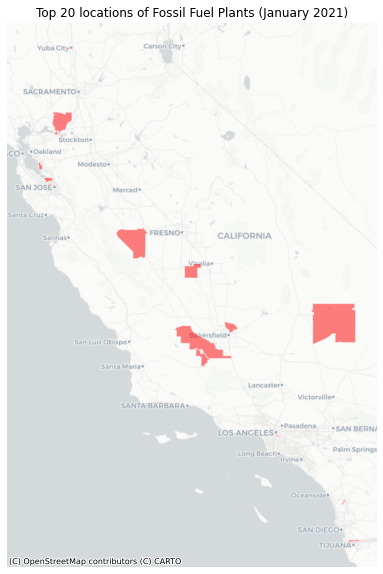

In [34]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf_sortbyces.sort_values(by='ffcount',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)
# title
ax.set_title('Top 20 locations of Fossil Fuel Plants (January 2021)')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Chloropleth map

Next we create a cholorpleth map of the distribution of fossil fuel plants

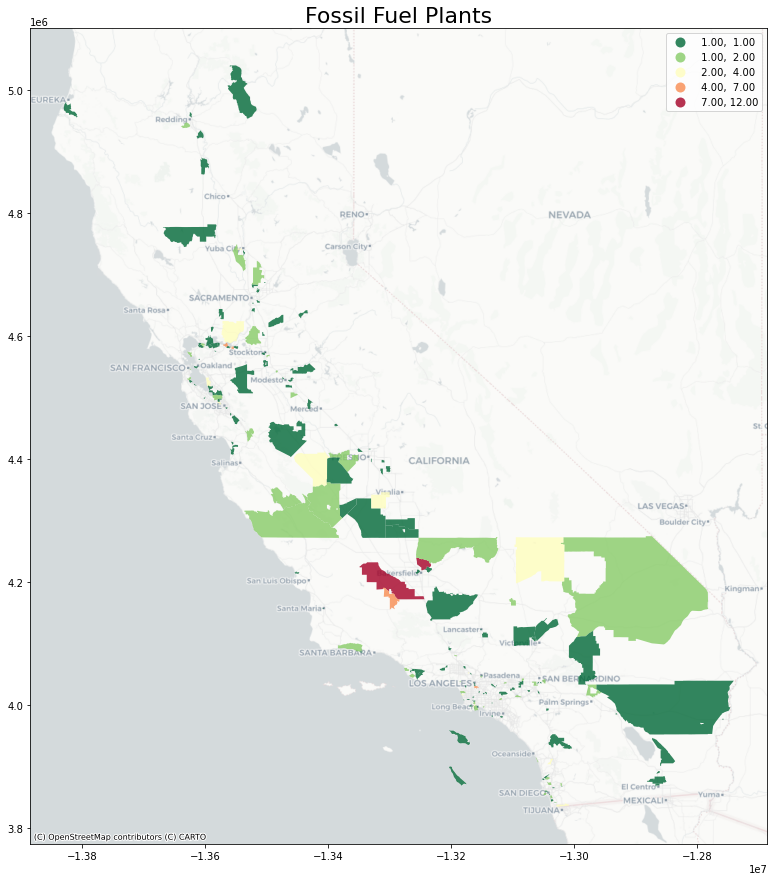

In [52]:
fig,ax = plt.subplots(figsize=(15,15))

gdf_sortbyces.plot(ax=ax,
        column='ffcount',
        legend=True,
        alpha=0.8,
         #underscore r reverses the scheme, so that green becomes low numbers and red high
        cmap='RdYlGn_r',
         #quntiles makes sure the data is divided equally
        scheme='naturalbreaks')
                   
                   
ax.set_title('Fossil Fuel Plants',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Spatial autocorrelation

In [36]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf_sortbyces,k=8)

# Row-standardization
wq.transform = 'r'

In [37]:
# create a new column for the spatial lag

gdf_sortbyces['ffcount_lag'] = lps.weights.lag_spatial(wq, gdf_sortbyces['ffcount'])


In [38]:
gdf_sortbyces.sample(5)[['ffcount','ffcount_lag']]

,ffcount,ffcount_lag
114,1,1.500
89,1,1.500
44,1,1.500
96,2,1.625
38,2,1.375


In [39]:

# create a column that calculates the difference betwen powerplant counts and lag
gdf_sortbyces['ffcount_lag_diff'] = gdf_sortbyces['ffcount'] - gdf_sortbyces['ffcount_lag']

In [40]:
# sort by lag differences
gdf_sortbyces.sort_values(by='ffcount_lag_diff')

,FIPS,CIscore,CIscoreP,geometry,ffcount,ffcount_lag,ffcount_lag_diff
56,6.029001e+09,43.88,81,"POLYGON ((-13252404.039 4219224.678, -13252199...",1,4.500,-3.500
137,6.029001e+09,23.26,46,"POLYGON ((-13238929.483 4224700.339, -13238530...",1,4.500,-3.500
34,6.107004e+09,50.48,89,"POLYGON ((-13284870.258 4289759.831, -13284854...",1,4.125,-3.125
124,6.083002e+09,28.12,56,"POLYGON ((-13406850.927 4157523.436, -13406863...",1,3.250,-2.250
84,6.029006e+09,36.40,71,"POLYGON ((-13201688.215 4180675.903, -13201685...",1,3.125,-2.125
...,...,...,...,...,...,...,...
65,6.013309e+09,41.37,78,"POLYGON ((-13563351.437 4586770.600, -13563229...",5,2.000,3.000
75,6.013306e+09,39.04,74,"POLYGON ((-13553318.864 4582846.247, -13553317...",7,1.750,5.250
181,6.037532e+09,0.00,0,"POLYGON ((-13159887.635 4030901.752, -13159680...",7,1.125,5.875
69,6.029005e+09,40.55,77,"POLYGON ((-13253076.632 4239211.826, -13252543...",12,3.125,8.875


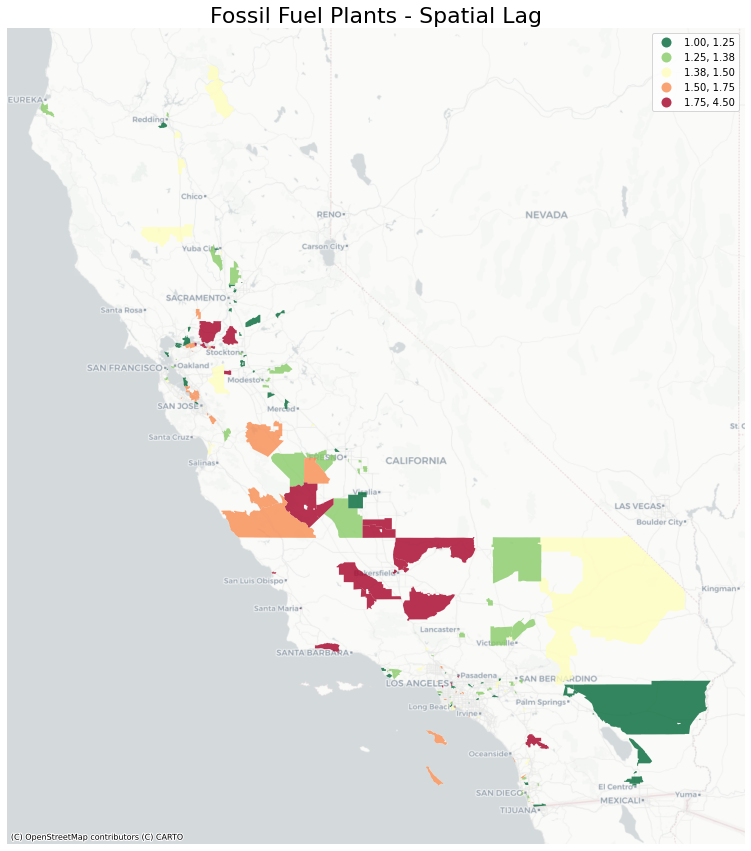

In [51]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth for ffcount
gdf_sortbyces.plot(ax=ax,
         figsize=(15,15),
         column='ffcount_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Fossil Fuel Plants - Spatial Lag',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Plot the spatial lag and regular maps side by side for fossil fuel

In [43]:
print(gdf_ces.crs)

epsg:3310


In [44]:
print(gdf_sortbyces.crs)

epsg:3857


In [45]:
gdf_crs = gdf_ces.to_crs(epsg=3857)

/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


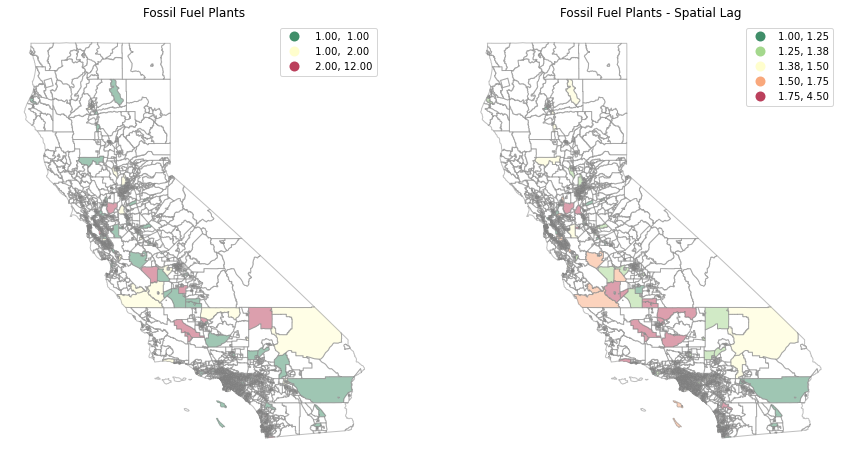

In [46]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)
# name each subplot
ax0, ax1 = ax[0], ax[1]

# regular count map on the left
gdf_sortbyces.plot(ax=ax[0], # this assigns the map to the left subplot
         column='ffcount', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
        legend = True,
         linewidth=0, 
         alpha=0.75, 
           )

gdf_crs.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax0)

ax[0].axis("off")
ax[0].set_title("Fossil Fuel Plants")

# spatial lag map on the right
gdf_sortbyces.plot(ax=ax[1], # this assigns the map to the right subplot
         column='ffcount_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0,
        legend=True,
         alpha=0.75
           )


gdf_crs.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax1)
ax[1].axis("off")
ax[1].set_title("Fossil Fuel Plants - Spatial Lag")

plt.show()

# Moran's Plot

In [47]:
y = gdf_sortbyces.ffcount
moran = Moran(y, wq)
moran.I

0.0800841195862226

We have a Moran's I-value of 0.08

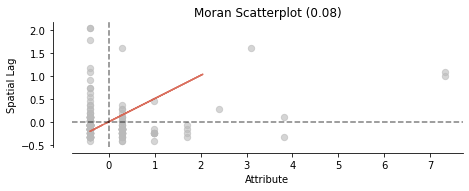

In [48]:
# Create a scatterplot of the Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

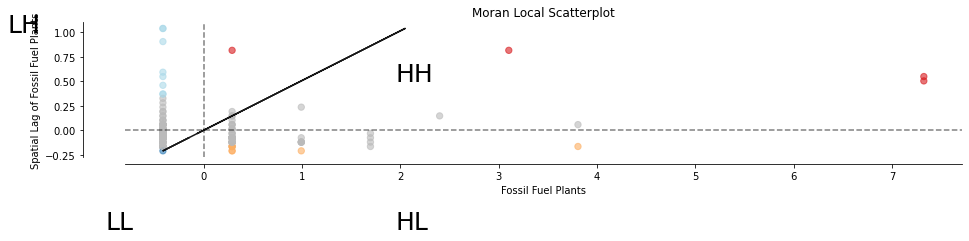

In [49]:
# Plot
fig,ax = plt.subplots(figsize=(15,15))

#define lisa 
lisa = esda.moran.Moran_Local(y, wq)

#create plot
moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Fossil Fuel Plants")
ax.set_ylabel('Spatial Lag of Fossil Fuel Plants')

# add labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()


In the scatterplot above, the colored dots represents the rows (census block groups) that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated geographies.

Next we visualize the spatially significant clusters using the lisa_cluster function

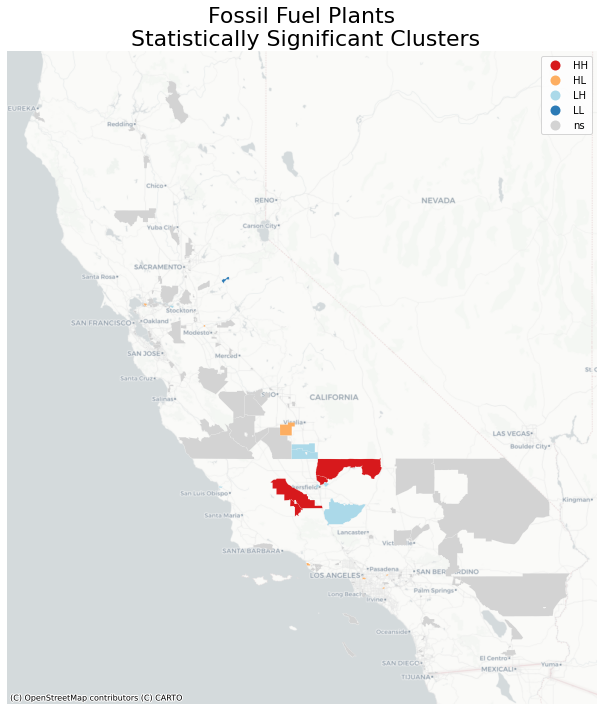

In [54]:
# use LISA cluster function
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_sortbyces, p=0.05, ax=ax)


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

ax.set_title('Fossil Fuel Plants\n Statistically Significant Clusters',fontsize=22)

plt.show()

We found a census tract outlier in which a low value (low number of fossil fuel plants) is surrounded primarily by census tracts with a lot of fossil fuel plants. 


# Folium Map

Next, I want to create an interactive folium map of just the significant clusters. First, I create a new column in my dataframe for significance. Then, I create a new datagrame of only the significant tracts. 

In [65]:
#creates new columns in df for significance
sig = 1 * (lisa.p_sim < 0.05)
gdf_sortbyces['p-sim'] = lisa.p_sim
gdf_sortbyces['sig'] = sig
gdf_sortbyces[['sig','p-sim']].head()

#subset to only keep significant tracts
ff_sig = gdf_sortbyces[gdf_sortbyces['p-sim'] < 0.05]
ff_sig

,FIPS,CIscore,CIscoreP,geometry,ffcount,ffcount_lag,ffcount_lag_diff,p-sim,sig
18,6.037402e+09,57.32,95,"POLYGON ((-13112504.160 4037249.746, -13111962...",2,1.125,0.875,0.047,1
27,6.107004e+09,52.66,91,"POLYGON ((-13260988.665 4303729.754, -13260566...",1,2.625,-1.625,0.048,1
33,6.111003e+09,50.56,89,"POLYGON ((-13273730.628 4060494.992, -13272691...",2,1.125,0.875,0.045,1
34,6.107004e+09,50.48,89,"POLYGON ((-13284870.258 4289759.831, -13284854...",1,4.125,-3.125,0.001,1
56,6.029001e+09,43.88,81,"POLYGON ((-13252404.039 4219224.678, -13252199...",1,4.500,-3.500,0.001,1
64,6.029003e+09,41.58,78,"POLYGON ((-13319116.920 4231940.423, -13318798...",12,3.000,9.000,0.012,1
69,6.029005e+09,40.55,77,"POLYGON ((-13253076.632 4239211.826, -13252543...",12,3.125,8.875,0.005,1
72,6.059012e+09,39.88,76,"POLYGON ((-13118537.008 4011175.990, -13118178...",2,1.000,1.000,0.001,1
84,6.029006e+09,36.40,71,"POLYGON ((-13201688.215 4180675.903, -13201685...",1,3.125,-2.125,0.010,1
94,6.013302e+09,33.72,66,"POLYGON ((-13549232.786 4582699.474, -13548852...",1,2.625,-1.625,0.046,1


Now, I get mapping. First, I need to import the folium library. It's a world map, so then I find the mean latitude and longitudes in my dataset to center the folium map on my desired geography.

In [66]:
import folium

In [72]:
latitude = join.Lat.mean()
latitude

36.01258129195177

In [73]:
longitude = join.Lon.mean()
longitude

-119.28023892789895

In [75]:
m = folium.Map(location=[latitude,longitude], zoom_start=11)
m

Above, I produced the mean latitude and longitudes of my dataset, and center the folium map on these points. It worked! 

Next, I create a folium chloropleth map 

In [83]:
#bins_interval = [0, 20, 30, 40, 50, 60, 70, 80, 100]
m10 = folium.Map(location=[33.99169246896552, -117.272919], 
               zoom_start = 10,
               tiles='CartoDB positron')
choropleth = folium.Choropleth(
                  geo_data=gdf_sortbyces, 
                  data=ff_sig,         
                  key_on='feature.properties.FIPS',
                  columns=['FIPS', 'ffcount_lag'],
                  fill_color='YlOrRd',
                  line_weight=.5, 
                  line_color='#252525',
                  fill_opacity=0.5,
                  line_opacity=1,
                  nan_fill_color='grey',
                  nan_fill_opacity=0,
                  #bins=[float(x) for x in bins_interval],
                  ).add_to(m10)   
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['ffcount', 'CIscoreP'],labels=True)
)
m10

In [85]:
# save as html file
m10.save('FFsig2.html')